In [0]:
### PREAMBLE
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

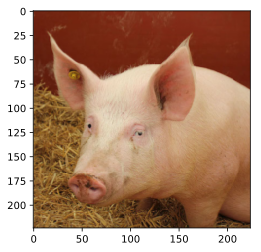

In [3]:
from PIL import Image
from torchvision import transforms

# read the image, resize to 224 and convert to PyTorch Tensor
pig_img = Image.open("pig.jpg")
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
pig_tensor = preprocess(pig_img)[None,:,:,:]

# plot image (numpy using HWC whereas Pytorch uses CHW, so we need to convert)
plt.imshow(pig_tensor[0].numpy().transpose(1,2,0))

 Load the pre-trained ResNet50 model and apply it to the image.

In [4]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images, 
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.eval();

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 156429643.46it/s]


In [0]:
# form predictions
pred = model(norm(pig_tensor))

Pred contains a 1000 dimensional vector containing the class logits for the 1000 imagenet classes.

In [6]:
import json
with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
print(imagenet_classes[pred.max(dim=1)[1].item()])

hog


In [8]:
# 341 is the class index corresponding to "hog"
print(nn.CrossEntropyLoss()(model(norm(pig_tensor)),torch.LongTensor([341])).item())

0.0038814544677734375


A loss of 0.0039 is pretty small: by the conventions above, that would correspond to an $\exp(-0.0039) \approx 0.996$ probability that the classifier believes this to be a pig.

In [9]:
import torch.optim as optim
epsilon = 2./255

delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=1e-1)

for t in range(30):
    pred = model(norm(pig_tensor + delta))
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([341]))
    if t % 5 == 0:
        print(t, loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)
    
print("True class probability:", nn.Softmax(dim=1)(pred)[0,341].item())

0 -0.0038814544677734375
5 -0.0069332122802734375
10 -0.015836715698242188
15 -0.08090496063232422
20 -12.150151252746582
25 -13.84597396850586
True class probability: 4.661520502935446e-09


After 30 gradient steps, the ResNet50 thinks that this has less than a $10^{-5}$ chance of being a pig.  

Predicted class:  wombat
Predicted probability: 0.9999804496765137


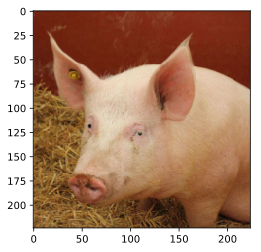

In [11]:
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())
plt.imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))

So what does this wombat-pig look like?  Extremely similar to our original pig, unfortunately.

Here in fact is the `delta` we added to the image, heavily zoomed in by a factor of 50 because it would be impossible to see otherwise.

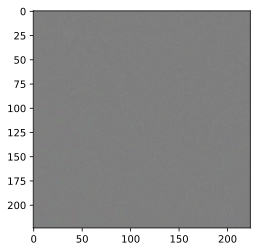

In [12]:
plt.imshow((delta+0.5)[0].detach().numpy().transpose(1,2,0))

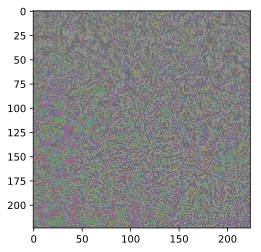

In [13]:
plt.imshow((10*delta+0.5)[0].detach().numpy().transpose(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


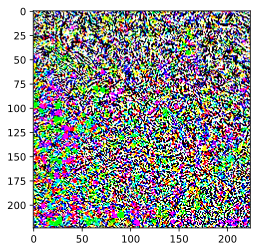

In [14]:
plt.imshow((100*delta+0.5)[0].detach().numpy().transpose(1,2,0))

In [0]:
input_tensor = None

def get_perturbation(image_tensor):
    import torch.optim as optim
    epsilon = 2./255

    delta = torch.zeros_like(image_tensor, requires_grad=True)
    opt = optim.SGD([delta], lr=1e-1)

    for t in range(30):
        pred = model(norm(image_tensor + delta))
        loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([341]))
        if t % 5 == 0:
            print(t, loss.item())
    
        opt.zero_grad()
        loss.backward()
        opt.step()
        delta.data.clamp_(-epsilon, epsilon)
    
    max_class = pred.max(dim=1)[1].item()
    print("Predicted class: ", imagenet_classes[max_class])
    print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())
    plt.imshow((image_tensor + delta)[0].detach().numpy().transpose(1,2,0))
    return delta
    

def normal_image(image_path = './elephant.jpeg'):
    # read the image, resize to 224 and convert to PyTorch Tensor
    input_img = Image.open(image_path)
    preprocess = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        ])
    input_tensor = preprocess(input_img)[None,:,:,:]

    # plot image (numpy using HWC whereas Pytorch uses CHW, so we need to convert)
    plt.imshow(input_tensor[0].numpy().transpose(1,2,0))
    
    #........Get the prediction
    
    pred = model(norm(input_tensor))
    
    print(pred.shape)
    #................Get the class
    import json
    with open("imagenet_class_index.json") as f:
        imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
        print(imagenet_classes[pred.max(dim=1)[1].item()])
    
    return input_tensor

torch.Size([1, 1000])
Indian_elephant


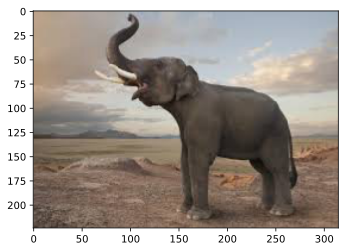

In [34]:
img = normal_image() 

0 -13.268754959106445
5 -27.702648162841797
10 -34.03812026977539
15 -31.003355026245117
20 -31.667869567871094
25 -28.409427642822266
Predicted class:  African_elephant
Predicted probability: 0.9575504064559937


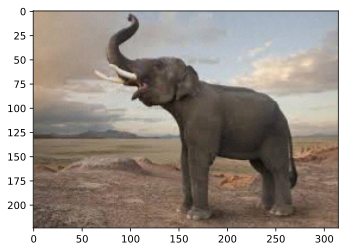

In [35]:
delta = get_perturbation(image_tensor = img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


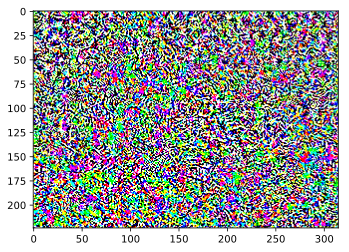

In [36]:
plt.imshow((100*delta+0.5)[0].detach().numpy().transpose(1,2,0))